# Recreating baseline models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objective**

* Recreating baseline models in the above article

**Files**

* [working-file: petter/baseline-garcia-working.ipynb](/petter/baseline-garcia-working.ipynb)
  * file contains scrappy code and various bits and pieces
* [current file - data extraction & eda](/petter/baseline-garcia-1-EDA.ipynb)
  * file contains data extraction and replicated EDA
  * saves data as csv for next file to pick up modelling
* [next file - baseline models](/petter/baseline-garcia-2-model.ipynb)

Outputs to be replicated

![example-activity-data-24-hours](./_images/2024-03-09-15-14-28.png)



## Preprocessing

* Minimal preprocessing

In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Extract data from folder

Function below extracts data from the `Depresjon` folder and stores in a `Pandas` dataframe.

In [2]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [3]:
# set folderpath
folderpath = '../data/depresjon'

# extract full ds, no csv
df = extract_from_folder(folderpath)


### Data reduction (as per `scores.csv`)

The Garcia baseline models are most likely *reduced* by `number of days` columns in `scores.csv` dataset.  

It is not clear whether this is the only reduction / data cleansing.  

I have created two reduced dataframes: 

1. **garcia_full_scoreNum** - dataframe reduced by `scores.csv` and only full days (1440 rows) are kept
2. **garcia_original_scoreNum** - dataframe reduced by `scores.csv` only - no further data reduction.


In [4]:
import pandas as pd

def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    #full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df

def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv', save_to_csv=True, output_csv_path=None):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): df containing the 'id' column.
        scores_csv_path (str, optional): path to the 'scores' CSV file. Defaults to '..\data\depresjon\scores.csv'.
        save_to_csv (bool, optional): save the updated df to a CSV file? Defaults to True.
        output_csv_path (str, optional): csv filepath. Required if save_to_csv is True.
        

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    # drop cols number, days, gender, age, afftype, melanch, inpatient, edu, marriage, work, madrs1, madrs2
    cols = ['number', 'number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']
    df_filtered.drop(cols, axis=1, inplace=True)
    

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_filtered.to_csv(output_csv_path, index=False)
            print(f"\n\ndf saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")

    return df_filtered



In [21]:
# set filepaths
scores_csv_path = '../data/depresjon/scores.csv'
garcia_full_scoreNum = '../data/petter/baseline-garcia-full-scoreNum.csv'
garcia_original_scoreNum = '../data/petter/baseline-garcia-original-scoreNum.csv'

# full days - 1440 rows per day
garcia_full = preprocess_full_days(df)
# scores days - number of days per ID based on 'scores'
garcia_full_scoreNum = extract_days_per_scores(garcia_full, scores_csv_path, save_to_csv=True, output_csv_path=garcia_full_scoreNum)
# scores days - number of days per ID based on 'scores'
garcia_original_scoreNum = extract_days_per_scores(df, scores_csv_path, save_to_csv=True, output_csv_path=garcia_original_scoreNum)



id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]

full_days_df info:

<class 'pandas.core.frame.DataFrame'>
Index: 1481760 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1481760 non-null  datetime64[ns]
 1   date       1481760 non-null  datetime64[ns]
 2   activity   1481760 non-null  int64         
 3   id         1481760 non-null  object        
 4   label      1481760 non-null

C:\Users\zoona\AppData\Local\Temp\ipykernel_16336\328979493.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/baseline-garcia-full-scoreNum.csv


C:\Users\zoona\AppData\Local\Temp\ipykernel_16336\328979493.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/baseline-garcia-original-scoreNum.csv


### Identifying the number of rows used

In [25]:
# print number of unique id, date rows in each df
print("\nNumber of unique id, date rows in each df:\n")
print("garcia_original_scoreNum: ", len(garcia_original_scoreNum.groupby(['id', 'date'])))
print("garcia_full_scoreNum: ", len(garcia_full_scoreNum.groupby(['id', 'date'])))



Number of unique id, date rows in each df:

garcia_original_scoreNum:  748
garcia_full_scoreNum:  693


## Dataset description

"The total number of collected days was **693 comprising 402 days in the control group and 291** in the condition group (Figure 2). Note that the actigraph files might contain more days but only the first n days were considered in our analysis. Where n is the number of days reported in the days column from the scores.csv file." (Garcia-Ceja et al., 2018)

Therefore - I am going to proceed with `garcia_full_scoreNum` which has 693 days.

In [49]:
# count of unique id, date by label
print("\nCount of unique id, date by label:\n")
# label 0
print("garcia_full_scoreNum label 0: ", len(garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby(['id', 'date'])))
# label 1
print("garcia_full_scoreNum label 1: ", len(garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby(['id', 'date'])))



Count of unique id, date by label:

garcia_full_scoreNum label 0:  402
garcia_full_scoreNum label 1:  291


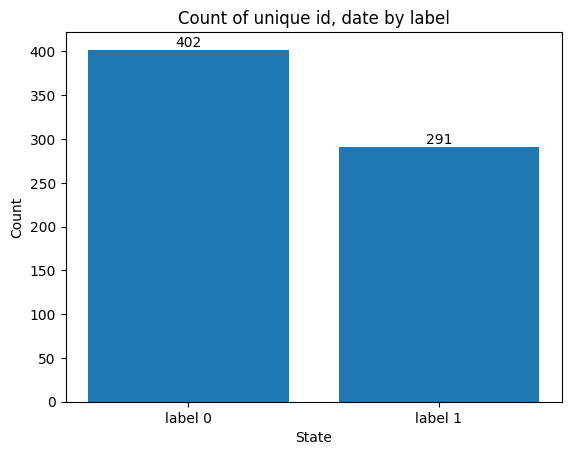

In [50]:


import matplotlib.pyplot as plt

# create a list of labels
labels = ['label 0', 'label 1']

# create a list of counts
counts = [len(garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby(['id', 'date'])),
          len(garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby(['id', 'date']))]

# create a bar plot
plt.bar(labels, counts)

# add labels and title
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Count of unique id, date by label')

# add total count on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# display the plot
plt.show()



Original from article: 

![distribution-days-by-state](./_images/2024-03-09-15-15-40.png)

The statistics of collected days by group matches:

![statistics-by-group](./_images/2024-03-09-15-14-59.png)

In [44]:
# print head
#print(garcia.head())

# print shape
#print(garcia.shape)

# print average, min, max, sd days for label 0
print(f"Average number of days for control (label=0): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for control (label=0): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby('id').size().std()/1440:.2f}")
print(f"Max number of days for control (label=0): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby('id').size().max()/1440:.2f}")
print(f"Min number of days for control (label=0): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby('id').size().min()/1440:.2f}")
print("\n")

# print average, min, max, sd days for label 0
print(f"Average number of days for condition (label=1): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby('id').size().mean()/1440:.2f}")
print(f"SD number of days for condition (label=1): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby('id').size().std()/1440:.2f}")
print(f"Max number of days for condition (label=1): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby('id').size().max()/1440:.2f}")
print(f"Min number of days for condition (label=1): {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby('id').size().min()/1440:.2f}")

Average number of days for control (label=0): 12.56
SD number of days for control (label=0): 2.31
Max number of days for control (label=0): 20.00
Min number of days for control (label=0): 8.00


Average number of days for condition (label=1): 12.65
SD number of days for condition (label=1): 2.77
Max number of days for condition (label=1): 18.00
Min number of days for condition (label=1): 5.00


### Days by id, label

C:\Users\zoona\AppData\Local\Temp\ipykernel_16336\160726763.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])


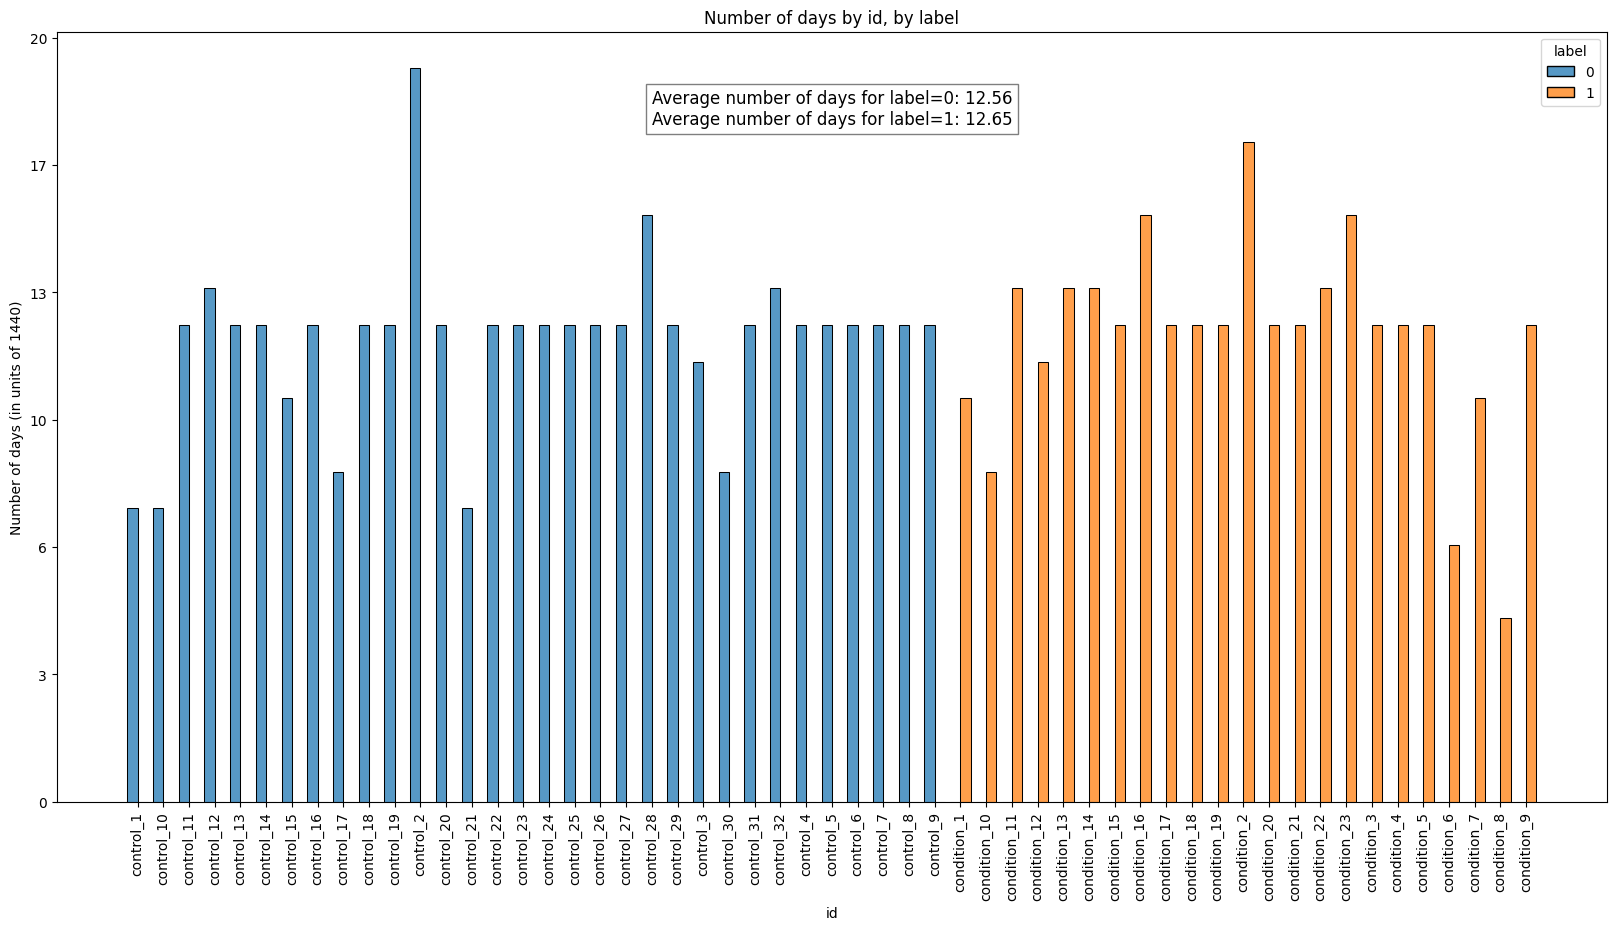

In [46]:

# plot histogram of days by id, by label
plt.figure(figsize=(20,10))
sns.histplot(data=garcia_full_scoreNum, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')
plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])
# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()



### Heatmaps

The original article contains heatmaps of *normalised* activity levels for each group, by weekdays and hours of day.

![heatmap-activity-by-control-group](./_images/2024-03-09-15-16-14.png)

![heatmap-activity-by-condition-group](./_images/2024-03-09-15-16-47.png)

#### Create normalised data

In [47]:

# normalise the activity column
scaler = StandardScaler()
garcia_full_scoreNum['activity_norm'] = scaler.fit_transform(garcia_full_scoreNum[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
garcia_full_scoreNum['day_of_week'] = garcia_full_scoreNum['timestamp'].dt.dayofweek
garcia_full_scoreNum['hour_of_day'] = garcia_full_scoreNum['timestamp'].dt.hour

# split df by label 
control = garcia_full_scoreNum[garcia_full_scoreNum['label'] == 0]
condition = garcia_full_scoreNum[garcia_full_scoreNum['label'] == 1]

# pivot table to reshape the data for the heatmap
control_hm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')
condition_hm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')

# pivot table to reshape the data for the heatmap - normalised
control_hm_norm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')
condition_hm_norm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')

### Recreate normalised Heatmaps

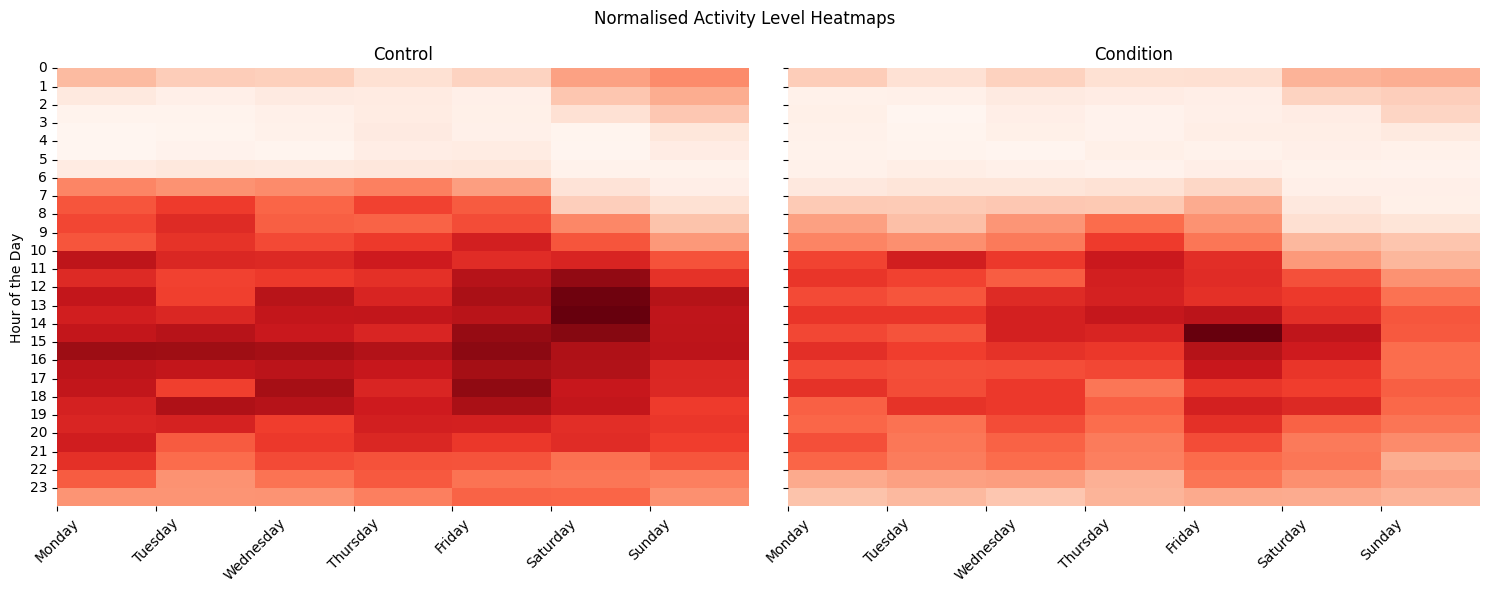

In [48]:
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[0])
#axs[0].set_xlabel('Day of the Week')
axs[0].set_xlabel('')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Control')
axs[0].set_yticks(range(0, 24))
axs[0].set_yticklabels(range(0, 24), rotation=0)  
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[1])
#axs[1].set_xlabel('Day of the Week')
axs[1].set_xlabel('')
#axs[1].set_ylabel('Hour of the Day')
axs[1].set_ylabel('') 
axs[1].set_title('Condition')
axs[1].set_yticks(range(0, 24))
#axs[1].set_yticklabels(range(0, 24), rotation=0)
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

# add shared title
plt.suptitle('Normalised Activity Level Heatmaps')

plt.tight_layout()
plt.show()

## Next: baseline modelling

See: 

[baseline-garcia-2-model](./baseline-garcia-2-model.ipynb)